In [1]:
import os
import subprocess
import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import functions as F
from pyspark.sql.functions import explode, col, count, from_unixtime, floor, date_format, hour, lower, lit, size
from pyspark.sql.types import *
from pyspark.sql.functions import sum as spark_sum
from functools import reduce
from pyspark.ml.feature import Tokenizer, HashingTF, MinHashLSH

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [3]:
gcs_folder = 'gs://msca-bdp-data-open/final_project_git'

## Data Cleaning Functions

In [4]:
def null_count(df):
    return df.select([
    F.sum(F.col(c).isNull().cast("int")).alias(c) 
     for c in df.columns
    ]).show(truncate=False)

In [5]:
def show_duplicates(df):
    df.groupBy(*df.columns) \
    .agg(count("*").alias("duplicate_count")) \
    .filter(col("duplicate_count") > 1) \
    .show(truncate=False)

# Languages Data 

In [6]:
df_languages = spark.read.parquet(os.path.join(gcs_folder, 'languages'))
print(f'Records read from dataframe *languages*: {df_languages.count():,.0f}')
df_languages.printSchema()

Records read from dataframe *languages*: 3,325,634
root
 |-- repo_name: string (nullable = true)
 |-- language: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- bytes: long (nullable = true)



In [7]:
# Taking a sample of the data
sample_df_languages = df_languages.sample(fraction = 0.01, seed = 42)
sample_df_languages.show(5)

+--------------------+--------------------+
|           repo_name|            language|
+--------------------+--------------------+
|  chadversary/cmocka|[{C, 180250}, {C+...|
|NA62/triggerlessD...|[{C, 353}, {C++, ...|
| TheZoq2/ArcticSeals|[{C, 12755}, {C++...|
|    ThomasAdam/moxfm|[{C, 466237}, {C+...|
|JIEgOKOJI/nginx-rtmp|[{C, 963225}, {HT...|
+--------------------+--------------------+
only showing top 5 rows



In [8]:
# Missing Values
null_count(sample_df_languages)

+---------+--------+
|repo_name|language|
+---------+--------+
|0        |0       |
+---------+--------+



In [9]:
# Duplicate values
show_duplicates(sample_df_languages)

+---------+--------+---------------+
|repo_name|language|duplicate_count|
+---------+--------+---------------+
+---------+--------+---------------+



In [10]:
# Transform the 'language' array into individual rows, creating one entry per language per repository
exploded_df_langs = sample_df_languages.withColumn("languages", explode("language"))

exploded_df_langs.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- language: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- bytes: long (nullable = true)
 |-- languages: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- bytes: long (nullable = true)



In [11]:
# Extract necessary fields: repository name, language name, and byte count
flattened_df_langs = exploded_df_langs.select(
    "repo_name",
    col("languages.name").alias("language"),
    col("languages.bytes").alias("bytes")
)

flattened_df_langs.show(5, truncate=False)

+----------------------------+--------+------+
|repo_name                   |language|bytes |
+----------------------------+--------+------+
|chadversary/cmocka          |C       |180250|
|chadversary/cmocka          |C++     |1616  |
|NA62/triggerlessDataReceiver|C       |353   |
|NA62/triggerlessDataReceiver|C++     |6752  |
|TheZoq2/ArcticSeals         |C       |12755 |
+----------------------------+--------+------+
only showing top 5 rows



### 10 most popular languages by number of repository 

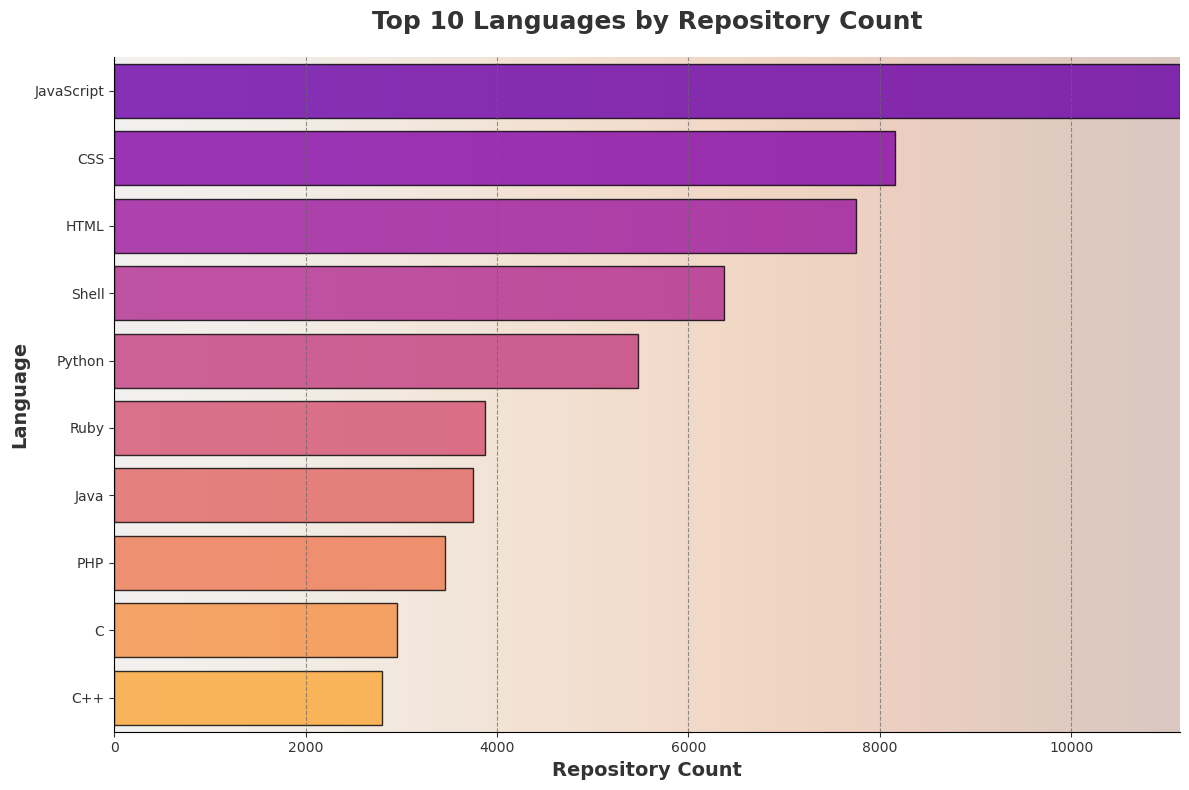

Top 10 Languages by Repository Count:


+----------+----------------+
|  language|repository_count|
+----------+----------------+
|JavaScript|           11135|
|       CSS|            8159|
|      HTML|            7748|
|     Shell|            6371|
|    Python|            5470|
|      Ruby|            3875|
|      Java|            3752|
|       PHP|            3456|
|         C|            2958|
|       C++|            2802|
+----------+----------------+
only showing top 10 rows



In [12]:
df_language_distribution = (
    flattened_df_langs
    .groupBy("language")
    .agg(count("*").alias("repository_count"))
    .orderBy(col("repository_count"), ascending=False)
)

# Step 2: Convert the top 10 results to a Pandas DataFrame
top_languages = df_language_distribution.limit(10).toPandas()

# Step 3: Create a colorful bar plot
plt.figure(figsize=(12, 8))

# Add a gradient background
ax = plt.gca()
ax.set_facecolor("#f0f0f0")  # Light gray background
gradient = np.linspace(0, 1, 256).reshape(1, -1)
gradient = np.vstack((gradient, gradient))
ax.imshow(gradient, aspect="auto", cmap="Oranges", alpha=0.2, extent=(0, max(top_languages["repository_count"]), -0.5, len(top_languages) - 0.5))

# Create a gradient color palette for the bars
colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(top_languages)))  # Plasma colormap

# Customize the bar plot
bars = plt.barh(top_languages["language"], top_languages["repository_count"], color=colors, edgecolor="black", alpha=0.8)

# Add title and labels
plt.title("Top 10 Languages by Repository Count", fontsize=18, pad=20, color="#333333", fontweight="bold")
plt.xlabel("Repository Count", fontsize=14, color="#333333", fontweight="bold")
plt.ylabel("Language", fontsize=14, color="#333333", fontweight="bold")

# Add grid for better readability
plt.grid(axis="x", linestyle="--", alpha=0.7, color="#666666")

# Invert the y-axis to show the largest value at the top
plt.gca().invert_yaxis()

# Remove spines (top and right borders)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Customize tick colors
plt.tick_params(axis="x", colors="#333333")
plt.tick_params(axis="y", colors="#333333")

# Show the plot
plt.tight_layout()
plt.show()

# Step 4: Show the top 10 results in the console
print("Top 10 Languages by Repository Count:")
df_language_distribution.show(10)

### 10 most popular languages by byte size

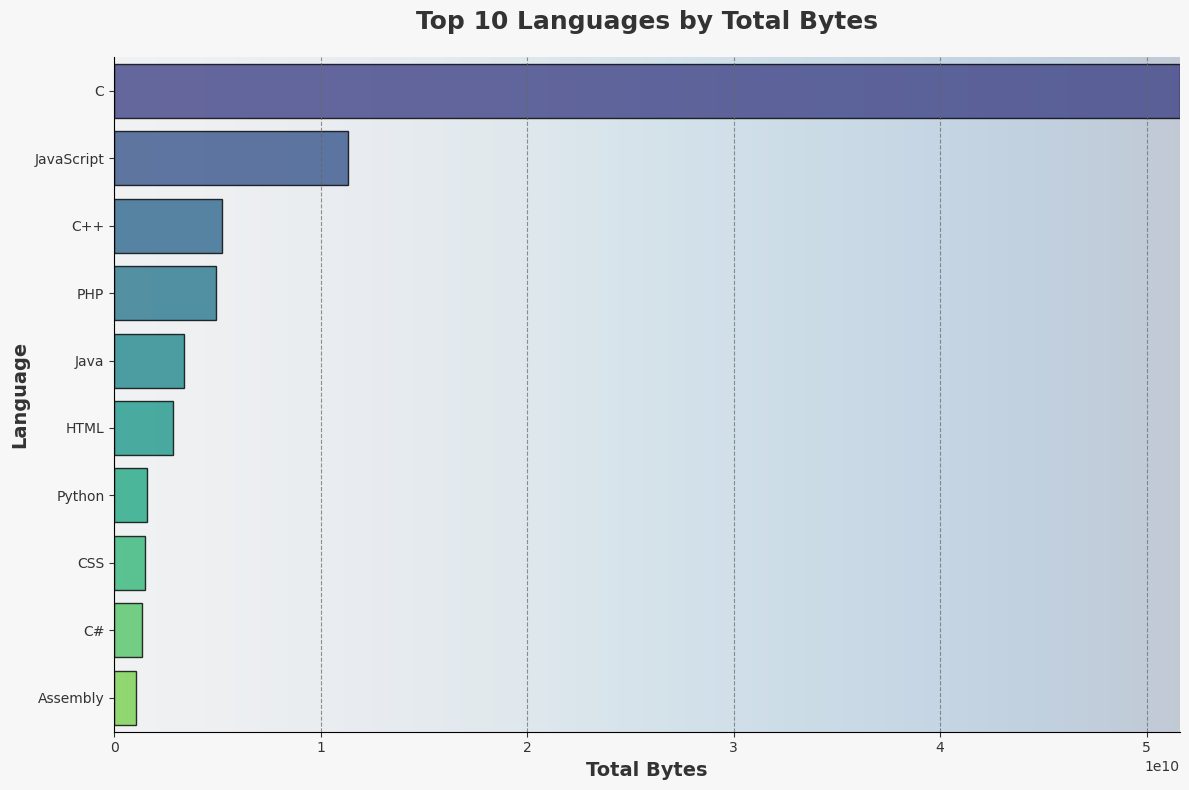

Top 10 Languages by Total Bytes:


+----------+-----------+
|  language|total_bytes|
+----------+-----------+
|         C|51617737723|
|JavaScript|11340186426|
|       C++| 5201901525|
|       PHP| 4921504411|
|      Java| 3375664439|
|      HTML| 2853363142|
|    Python| 1599406408|
|       CSS| 1490682654|
|        C#| 1370945385|
|  Assembly| 1075066541|
+----------+-----------+
only showing top 10 rows



In [13]:
# Step 1: Aggregate and order the data
df_language_usage = (
    flattened_df_langs
    .groupBy("language")
    .agg(spark_sum("bytes").alias("total_bytes"))
    .orderBy(col("total_bytes"), ascending=False)
)

# Step 2: Convert the top 10 results to a Pandas DataFrame
top_languages = df_language_usage.limit(10).toPandas()

# Step 3: Create a pretty bar plot
plt.figure(figsize=(12, 8), facecolor="#f7f7f7")

# Add a gradient background
ax = plt.gca()
ax.set_facecolor("#f0f0f0")  # Light gray background
gradient = np.linspace(0, 1, 256).reshape(1, -1)
gradient = np.vstack((gradient, gradient))
ax.imshow(gradient, aspect="auto", cmap="Blues", alpha=0.2, extent=(0, max(top_languages["total_bytes"]), -0.5, len(top_languages) - 0.5))

# Create a gradient color palette for the bars
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(top_languages)))  # Viridis colormap

# Customize the bar plot
bars = plt.barh(top_languages["language"], top_languages["total_bytes"], color=colors, edgecolor="black", alpha=0.8)

# Add title and labels
plt.title("Top 10 Languages by Total Bytes", fontsize=18, pad=20, color="#333333", fontweight="bold")
plt.xlabel("Total Bytes", fontsize=14, color="#333333", fontweight="bold")
plt.ylabel("Language", fontsize=14, color="#333333", fontweight="bold")

# Add grid for better readability
plt.grid(axis="x", linestyle="--", alpha=0.7, color="#666666")

# Invert the y-axis to show the largest value at the top
plt.gca().invert_yaxis()

# Remove spines (top and right borders)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Customize tick colors
plt.tick_params(axis="x", colors="#333333")
plt.tick_params(axis="y", colors="#333333")

# Show the plot
plt.tight_layout()
plt.show()

# Step 4: Show the top 10 results in the console
print("Top 10 Languages by Total Bytes:")
df_language_usage.show(10)

### Join Commits data

In [14]:
df_commits = spark.read.parquet(os.path.join(gcs_folder, 'commits'))

print(f'Records read from dataframe *commits*: {df_commits.count():,.0f}')

df_commits.printSchema()

sample_df_commits = df_commits.sample(fraction = 0.01, seed = 42)

df_commits_cleaned = sample_df_commits.select(
    col("commit"),
    col("tree"),
    col("parent"),
    
    # Extract author details
    col("author.name").alias("author_name"),
    col("author.email").alias("author_email"),
    from_unixtime(col("author.time_sec")).alias("author_time"), 
    
    # Extract committer details
    col("committer.name").alias("committer_name"),
    col("committer.email").alias("committer_email"),
    from_unixtime(col("committer.time_sec")).alias("committer_time"),
    
    # Commit metadata
    col("subject"),
    col("message"),
    
    # Extract first element from 'repo_name' array
    col("repo_name")[0].alias("repo_name")
)

commit_lang_merged = df_commits_cleaned.join(flattened_df_langs, on="repo_name", how="inner")

Records read from dataframe *commits*: 265,419,190
root
 |-- commit: string (nullable = true)
 |-- tree: string (nullable = true)
 |-- parent: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- author: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- time_sec: long (nullable = true)
 |    |-- tz_offset: long (nullable = true)
 |    |-- date: struct (nullable = true)
 |    |    |-- seconds: long (nullable = true)
 |    |    |-- nanos: long (nullable = true)
 |-- committer: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- time_sec: long (nullable = true)
 |    |-- tz_offset: long (nullable = true)
 |    |-- date: struct (nullable = true)
 |    |    |-- seconds: long (nullable = true)
 |    |    |-- nanos: long (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- trailer: array (n

## Trend analysis of Top 5 programming languages over time

In [15]:
# Extract year from author_time and group by year and language
commit_lang_merged = commit_lang_merged.withColumn("year", col("author_time").substr(1, 4))
language_trends = commit_lang_merged.groupBy("year", "language").count().orderBy("count", ascending=False)
language_trends.show(20, truncate=False)

# Convert to Pandas and pivot for visualization
trends_pd = language_trends.toPandas()
pivot_trends = trends_pd.pivot(index="year", columns="language", values="count").fillna(0)

+----+----------+-----+
|year|language  |count|
+----+----------+-----+
|2017|JavaScript|1814 |
|2017|HTML      |1789 |
|2016|JavaScript|1730 |
|2017|Shell     |1711 |
|2015|JavaScript|1679 |
|2016|HTML      |1673 |
|2016|Shell     |1624 |
|2015|HTML      |1589 |
|2015|Shell     |1574 |
|2014|Shell     |1448 |
|2017|Python    |1441 |
|2015|CSS       |1379 |
|2014|JavaScript|1345 |
|2017|CSS       |1340 |
|2016|CSS       |1327 |
|2015|Python    |1201 |
|2014|Python    |1170 |
|2014|CSS       |1153 |
|2018|HTML      |1133 |
|2016|Python    |1125 |
+----+----------+-----+
only showing top 20 rows



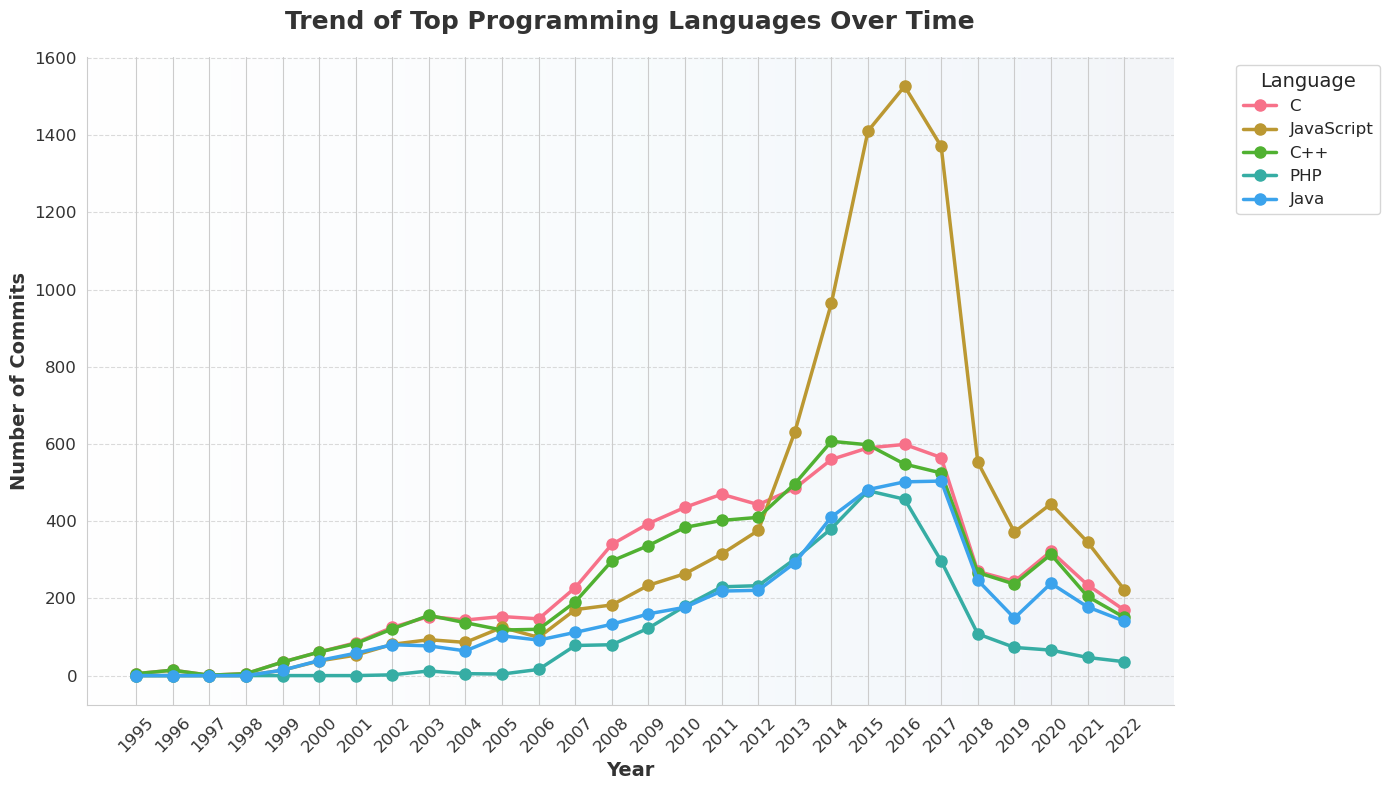

In [16]:
# Select top 5 languages by popularity
top_langs = top_languages["language"].head(5).tolist()
pivot_top = pivot_trends[top_langs]

# Set a modern style and color palette
sns.set_style("whitegrid")
sns.set_palette("husl")

# Plot trends for top languages
plt.figure(figsize=(14, 8))
for lang in top_langs:
    plt.plot(pivot_top.index, pivot_top[lang], marker="o", markersize=8, linewidth=2.5, label=lang)

# Add title and labels with custom fonts
plt.title("Trend of Top Programming Languages Over Time", fontsize=18, pad=20, fontweight="bold", color="#333333")
plt.xlabel("Year", fontsize=14, fontweight="bold", color="#333333")
plt.ylabel("Number of Commits", fontsize=14, fontweight="bold", color="#333333")

# Customize legend
plt.legend(title="Language", title_fontsize=14, fontsize=12, bbox_to_anchor=(1.05, 1), loc="upper left")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12, color="#333333")
plt.yticks(fontsize=12, color="#333333")

# Add grid for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Remove top and right spines for a cleaner look
sns.despine()

# Add a light background gradient
ax = plt.gca()
gradient = np.linspace(0, 1, 256).reshape(1, -1)
gradient = np.vstack((gradient, gradient))
ax.imshow(gradient, aspect="auto", cmap="Blues", alpha=0.05, extent=(*ax.get_xlim(), *ax.get_ylim()))

# Tight layout to avoid overlapping elements
plt.tight_layout()

# Show the plot
plt.show()

## Trend analysis of keywords in top 5 languages

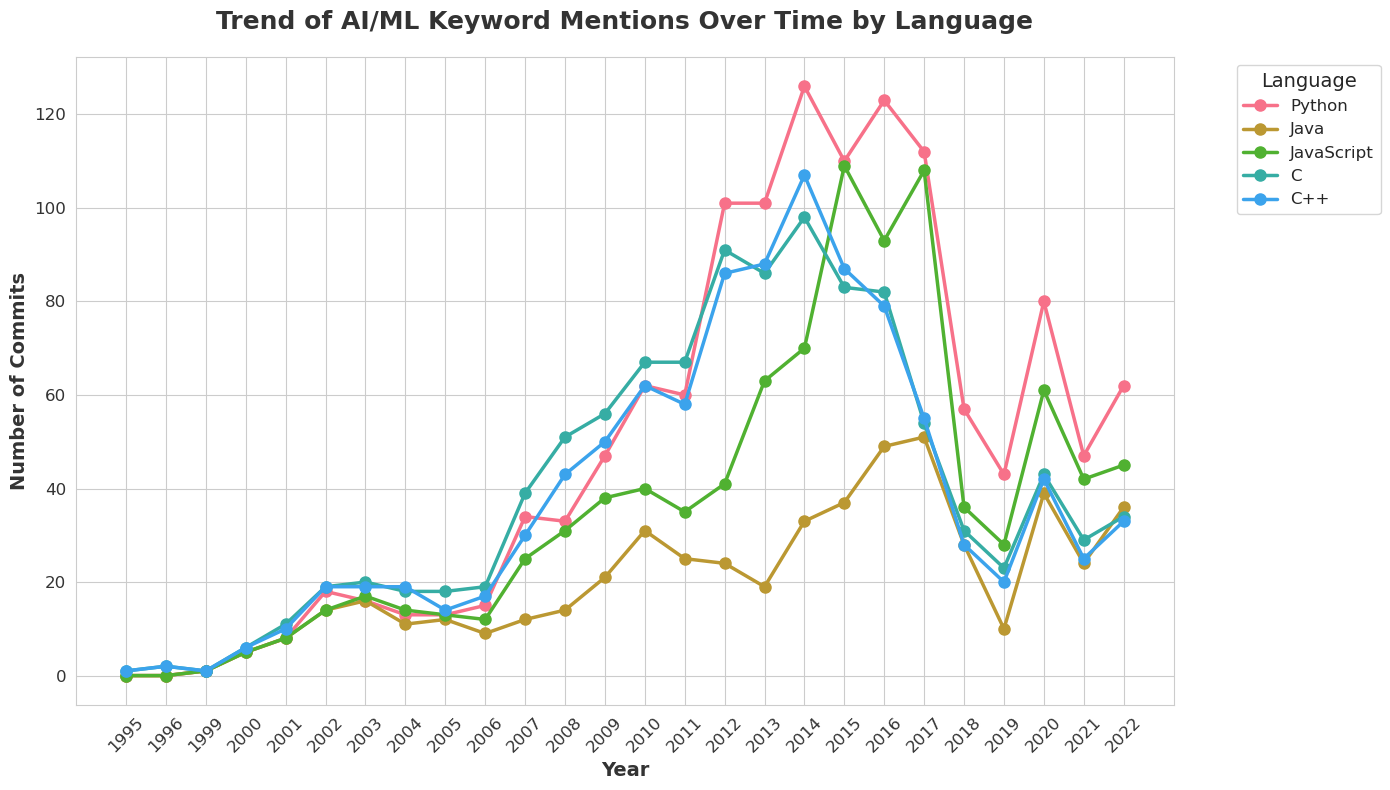

In [ ]:
# Define target languages and keywords
languages = ["Python", "Java", "JavaScript", "C", "C++"]
keywords = ["ai", "artificial intelligence", "data science", "machine learning", "ml", "deep learning"]

# Function to create a filter condition for keywords in commit messages
def create_keyword_filter(keywords):
    return reduce(lambda a, b: a | b, [lower(col("message")).contains(kw) for kw in keywords], lit(False))

# Filter and aggregate data for each language
keyword_trends = [
    commit_lang_merged.filter((col("language") == lang) & create_keyword_filter(keywords))
                      .withColumn("year", col("author_time").substr(1, 4))
                      .groupBy("year").count()
                      .withColumnRenamed("count", f"{lang}_count")
    for lang in languages
]

# Outer join all DataFrames on "year" and fill missing values with 0
keyword_trend_joined = reduce(lambda df1, df2: df1.join(df2, on="year", how="outer"), keyword_trends).fillna(0).orderBy("year")

# Convert to Pandas and sort by year
keyword_trend_pd = keyword_trend_joined.toPandas().sort_values("year")

# Plot trends with a modern design
sns.set_style("whitegrid")
plt.figure(figsize=(14, 8))
for lang in languages:
    plt.plot(keyword_trend_pd["year"], keyword_trend_pd[f"{lang}_count"], marker="o", markersize=8, linewidth=2.5, label=lang)

# Add title, labels, and legend
plt.title("Trend of AI/ML Keyword Mentions Over Time by Language", fontsize=18, pad=20, fontweight="bold", color="#333333")
plt.xlabel("Year", fontsize=14, fontweight="bold", color="#333333")
plt.ylabel("Number of Commits", fontsize=14, fontweight="bold", color="#333333")
plt.legend(title="Language", title_fontsize=14, fontsize=12, bbox_to_anchor=(1.05, 1), loc="upper left")

# Rotate x-axis labels and adjust layout
plt.xticks(rotation=45, fontsize=12, color="#333333")
plt.yticks(fontsize=12, color="#333333")
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
flattened_df_langs.distinct()